### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

# Chapter 01: Feature extraction exploration - BDLib2

A few ideas were taken from: [Hackers Realm](https://www.youtube.com/watch?v=hX2sOvrWC1Q).
***

## Check for GPU

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.3.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Libraries

In [3]:
import os
import urllib.request
import zipfile
import mimetypes
import warnings
import glob

import pandas     as pd
import numpy      as np
import seaborn    as sns

from matplotlib  import pyplot as plt


In [4]:
#import librosa
#import librosa.display
#import random
#import random
#import sklearn
#import itertools
#import time

#import IPython.display   as ipd
#import matplotlib.ticker as ticker
#import matplotlib as mp


#from tqdm        import tqdm
#from sklearn     import metrics
#from sklearn     import preprocessing
#from collections import Counter


#from sklearn.model_selection   import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
#from sklearn.model_selection   import GridSearchCV, learning_curve
#from sklearn.feature_selection import mutual_info_classif



#from sklearn.linear_model    import LogisticRegression
#from sklearn.naive_bayes     import GaussianNB
#from sklearn.svm             import SVC
#from sklearn.neighbors       import KNeighborsClassifier
#from sklearn.ensemble        import RandomForestClassifier
#from sklearn.neural_network  import MLPClassifier

#from matplotlib.patches      import Patch


# Solution to play .ogg files in the IPython 
# https://stackoverflow.com/questions/39077987/ipython-display-audio-cannot-correctly-handle-ogg-file-type

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

## Loading the dataset and defining global variables

Source: https://m3c.web.auth.gr/research/datasets/bdlib/

BDLib2 Environmental Sound Dataset
The library was created by identifying and isolating 10 s audio segments thatrepresent discrete sound categories from the following sources: BBC Complete Sound Effects Library(bbcsfx.acropolis.org.uk) and freesound.org. Particular care has been taken in the selection of thesegments in order to keep the sound samples clean of background noise and prevent overlapping ofthe sound classes.

The library is organized in the following 10 classes: airplanes, alarms, applause,birds, dogs, motorcycles, rain, rivers, sea waves, and thunders.

Our intention was to include classes ofsounds—encountered either in indoor or outdoor soundscapes—that are extensively used in similarrecognition schemes. Each class is equally represented in the database by 18 audio files with greatvariations between them, which reflect real life situations. All the recordings are uncompressed monoaudio files in WAV format, with a sampling rate of 44.1 kHz and 16 bit analysis.

Publications

[1] Bountourakis, V., Vrysis, L., & Papanikolaou, G. (2015). Machine learning algorithms for environmental sound recognition: Towards soundscape semantics. In Proceedings of the Audio Mostly 2015 on Interaction With Sound (pp. 1-7).

[2] Bountourakis, V., Vrysis, L., Konstantoudakis, K., & Vryzas, N. (2019, June). An Enhanced Temporal Feature Integration Method for Environmental Sound Recognition. In Acoustics (Vol. 1, No. 2, pp. 410-422). Multidisciplinary Digital Publishing Institute.

In [5]:
current_path = os.getcwd()
current_path

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master'

In [6]:
path = current_path + "\\" + "_dataset\BDLib2"

# Check if the folder exists, if not, create it
#if not os.path.exists(dataset):
#    os.makedirs(dataset)

#url         = 'https://research.playcompass.com/files/BDLib-2.zip'
#extract_dir = dataset
#zip_path, _ = urllib.request.urlretrieve(url)
#with zipfile.ZipFile(zip_path, "r") as f:
#    f.extractall(extract_dir) 

In [9]:
# Variables for Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 100
SR          = 44100

# Folder for results and pictures
path_pic    = current_path + "\\" + "BDLib2_results\\"

# Check if the folder exists, if not, create it
if not os.path.exists(path_pic):
    os.makedirs(path_pic)

subfolders  = next(os.walk(path))[1]
dict_list   = []
db_B        = pd.DataFrame(columns=['Class_categorical', 'Fold', 'File_name', 'Path'])
nom_dataset = 'BDlib2' 
csv_file    = 'BDlib2.csv'

In [10]:
sound_files = []
for folder in subfolders:
    os.chdir(path + "\\" + folder)
    sounds = (glob.glob('*.wav'))
    sound_files.append(sounds)

In [11]:
# Method to read the folders, sound files and create the dataframe

def readDoc(path: str, subfolders: str):

    for folder in subfolders:
        os.chdir(path + "\\" + folder)
        sounds = (glob.glob('*.wav'))
        for s in sounds:
            row_dict = {'Fold': folder,
                        'Class_categorical': s[:-6],
                        'File_name': s,
                        'Path': path + '\\' + folder + '\\' + s}
            dict_list.append(row_dict)
    return pd.DataFrame.from_dict(dict_list)


# Export the dataframe as CSV file
def exportCSV(path: str, db):

    os.chdir(path)
    db.to_csv(csv_file)
    print("\nCSV exported.\nCheck the folder", path)

In [12]:
db        = readDoc(path, subfolders)
db_unique = np.unique(db["File_name"])

print("\nClasses:\n--------------------")
print(db["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(db_unique))
print("Total number of WAV files.............: ", len(db))
db

exportCSV(path, db)


Classes:
--------------------
Class_categorical
airplane       18
alarms         18
applause       18
birds          18
dogs           18
motorcycles    18
rain           18
rivers         18
seawaves       18
thunders       18
Name: count, dtype: int64

Total number of unique files..........:  180
Total number of WAV files.............:  180

CSV exported.
Check the folder C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2


In [13]:
path, subfolders

('C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master\\_dataset\\BDLib2',
 ['fold-1', 'fold-2', 'fold-3'])

In [14]:
# Read the csv file created 

db = pd.read_csv(csv_file, dtype={'Class': str})
db = db.drop('Unnamed: 0', axis=1)

In [15]:
db

,Fold,Class_categorical,File_name,Path
0,fold-1,airplane,airplane01.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane01.wav
1,fold-1,airplane,airplane02.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane02.wav
2,fold-1,airplane,airplane03.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane03.wav
3,fold-1,airplane,airplane04.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane04.wav
4,fold-1,airplane,airplane05.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane05.wav
...,...,...,...,...
175,fold-3,thunders,thunders14.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders14.wav
176,fold-3,thunders,thunders15.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders15.wav
177,fold-3,thunders,thunders16.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders16.wav
178,fold-3,thunders,thunders17.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders17.wav


In [16]:
y = db['Class_categorical'].values
len(y)

180

In [17]:
print(np.unique(y))
print(len(np.unique(y)))

['airplane' 'alarms' 'applause' 'birds' 'dogs' 'motorcycles' 'rain'
 'rivers' 'seawaves' 'thunders']
10


In [18]:
# Method to create an one hot encoder vector (OHEV)

def OHEV(df: list, cat_class: str):
    
    df_class  = df[cat_class]
    
    return np.array(pd.get_dummies(df_class, columns = [str], dtype=int))

In [19]:
# Creates a OHEV for the audio classes

class_enc = OHEV(db, 'Class_categorical')
db.insert(loc = 2, column = 'Class_OHEV', value = class_enc.tolist())

In [20]:
db

,Fold,Class_categorical,Class_OHEV,File_name,Path
0,fold-1,airplane,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",airplane01.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane01.wav
1,fold-1,airplane,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",airplane02.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane02.wav
2,fold-1,airplane,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",airplane03.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane03.wav
3,fold-1,airplane,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",airplane04.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane04.wav
4,fold-1,airplane,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",airplane05.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-1\airplane05.wav
...,...,...,...,...,...
175,fold-3,thunders,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",thunders14.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders14.wav
176,fold-3,thunders,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",thunders15.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders15.wav
177,fold-3,thunders,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",thunders16.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders16.wav
178,fold-3,thunders,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",thunders17.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\BDLib2\fold-3\thunders17.wav


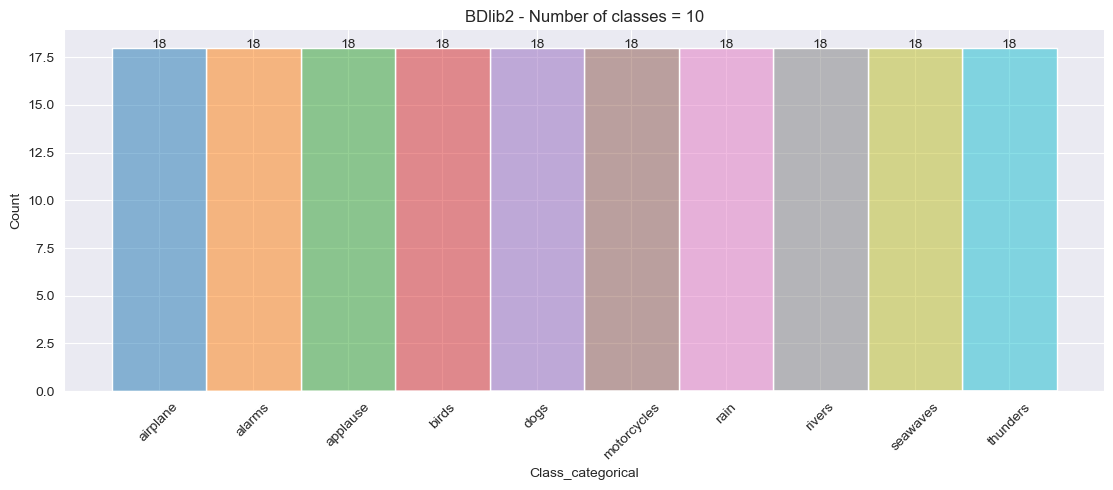

In [22]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = nom_dataset + ' - Number of classes = ' + str(len(pd.Series(db['Class_categorical']).unique()))
g = sns.displot(db,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()
plt.savefig(path_pic + '01_Feature_extraction_01.png')
plt.show()

## Exploratory data analysis

In [ ]:
# Procedure to read all files in each subfolder

def readFiles(path: str, subfolders: str):

    dict_list  = []
    for folder in subfolders:
        os.chdir(path + folder)
        sounds = (glob.glob('*.wav'))
        row_dict = {'Folder': [folder],
                    'File_name': sounds}
        dict_list.append(row_dict)
    return dict_list

In [ ]:
dbFiles = readFiles(path, subfolders)

In [ ]:
dbFiles

In [ ]:
for key,value in dbFiles[0].items():
    print(key, value)

In [ ]:
for key, value in dbFiles[0].items():
    count = len(list(filter(bool, value)))
    print(f"{key} has {count} items")

In [ ]:
print(dbFiles[0].get('Folder'),'\n\n',
      len(dbFiles[0].get('Folder')), 'element(s)','\n')
print(dbFiles[0].get('File_name'),'\n\n',
      len(dbFiles[0].get('File_name')), 'element(s)','\n')

In [ ]:
os.chdir(path + subfolders[0])

In [ ]:
pwd

In [ ]:
dbFiles[0]['File_name'][0]

In [ ]:
ipd.Audio('dogs06.wav')

In [ ]:
db.loc[db['File_name'] == 'dogs06.wav']

In [ ]:
!dir

In [ ]:
# Load the audio file as a floating point time series.
# Data = Sound amplitude
# Sampling rate = Number of samples per second (Hz)

data, sampling_rate = librosa.load('dogs06.wav', sr = SR)

In [ ]:
data

In [ ]:
sampling_rate

In [ ]:
len(data)

In [ ]:
plt.figure(figsize = (12,4))
librosa.display.waveshow(data, sr = sampling_rate, alpha = 0.5)
plt.tight_layout()
plt.title('BDLib2 - Wave form of dog bark')
plt.tight_layout()
plt.savefig(path_pic + '01_Feature_extraction_02.png')
plt.show()

In [ ]:
ipd.Audio('dogs06.wav')

In [ ]:
db

In [ ]:
# Procedure to get a folder, file name and its path ramdomly and show its wave form and content

def random_data (df: list, root_path: str):
    
    dict_rd   = random.choice(list(df))
    folder_rd = dict_rd['Folder'][0]
    file_rd   = random.choice(list(dict_rd['File_name']))
    path_rd   = os.path.join(root_path, folder_rd, file_rd)

    print('Folder.......:',folder_rd, '\n' 'File name....:', file_rd)
    print('Path.........:', path_rd)
    
    data, sampling_rate = librosa.load(path_rd, sr = SR)
    ipd.Audio(path_rd)

    plt.figure(figsize = (12,4))
    plt.title(f"BDLib2 - Wave form of {file_rd}, ({folder_rd})")
    librosa.display.waveshow(data, sr = sampling_rate, alpha = 0.5)
    plt.show()
    
    return folder_rd, file_rd, path_rd, data, sampling_rate

In [ ]:
random_folder, random_file, random_path, random_signal, random_sr = random_data(dbFiles, path)
ipd.Audio(random_path)

In [ ]:
len(random_signal)

In [ ]:
samples = range(len(random_signal))
samples

In [ ]:
random_sr

In [ ]:
tx = librosa.samples_to_time(samples, sr = random_sr)
len(tx)

In [ ]:
d = 1/random_sr
d

In [ ]:
d900 = 900*d
d900

In [ ]:
plt.figure(figsize = (12,4))
plt.plot(tx[10000:10900],random_signal[10000:10900])
name        = '...\\' + folder + '\\' + random_file
plt.title(f"BDLib2 - Wave form of 20ms of the file {random_file}, ({random_folder})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.savefig(path_pic + '01_Feature_extraction_03.png')
plt.tight_layout()
plt.show()

In [ ]:
# Compute and plot the magnitude spectrum of audio file

def plot_magnitude_spectrum(path: str, folder: str, file_name, path_pic, fn_picture, t_ratio=1):
    name        = '...\\' + folder + '\\' + file_name
        
    signal, sr  = librosa.load(path, sr=SR)
    ft = np.fft.fft(signal) 
    magnitude_spectrum = np.abs(ft) 

    # plot magnitude spectrum 
    plt.figure(figsize = (18, 5)) 

    frequency = np.linspace(0, sr, len (magnitude_spectrum)) 
    num_frequency_bins = int(len(frequency) * t_ratio) 

    plt.plot(frequency[:num_frequency_bins], magnitude_spectrum[:num_frequency_bins])
    plt.xlabel("Frequency (Hz) " ) 
    plt.title(f" BDLib2 - Magnitude spectrum for {name}")
    plt.tight_layout()
    plt.savefig(path_pic + fn_picture)
    plt.show() 

In [ ]:
plot_magnitude_spectrum(random_path, random_folder, random_file, path_pic, '01_Feature_extraction_04.png', 1) 

In [ ]:
plot_magnitude_spectrum(random_path, random_folder, random_file, path_pic, '01_Feature_extraction_05.png', 0.5) 

In [ ]:
# Compute and plot log-frequency power spectrogram with Short-Time Fourier Transform
# In the example below the power was eliminated to emphasize all frequencies in the plot. Adding the power
# after abs(X) --> abs(X)**2 would plot spectrograms with more emphasizes on the frequencies with higher power

def plot_spectrogram(path: str, folder: str, file_name):
    name        = '...\\' + folder + '\\' + file_name
        
    signal, sr  = librosa.load(path, sr=SR)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(signal)))
    
    plt.figure(figsize = (20, 8))
    
    librosa.display.specshow(spectrogram, sr = sr, y_axis = "log", x_axis='time')
    plt.colorbar(format = "%+2.0f dB")
    plt.title(f" BDLib2 - Log-frequency spectrogram for {name}")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.savefig(path_pic + '01_Feature_extraction_06.png')
    plt.show() 

In [ ]:
plot_spectrogram(random_path, random_folder, random_file)

In [ ]:
random_signal.size

In [ ]:
# Compute mel spectrogram and plot result

def mel_spectrogram(path: str, folder: str, file_name):
    name        = '...\\' + folder + '\\' + file_name
    
    signal, sr  = librosa.load(path, sr = SR)
    X, _        = librosa.effects.trim(signal)
    XS          = librosa.feature.melspectrogram(y=X, sr=SR, n_fft = FRAME_SIZE, hop_length = HOP_LENGTH, n_mels = 128)
    Xdb         = librosa.power_to_db(XS, ref=np.max)
   
    plt.figure(figsize = (20, 8))
    
    librosa.display.specshow(Xdb, sr=SR, x_axis='time', y_axis='mel')
    plt.colorbar(format = "%+2.0f dB")
    plt.title(f" BDLib2 - Mel frequency spectrogram for {name}")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.savefig(path_pic + '01_Feature_extraction_07.png')
    plt.show() 

In [ ]:
mel_spectrogram(random_path, random_folder, random_file)

In [ ]:
# Duration of one sample and the audio signal

duration_sr     = 1 / random_sr
duration_signal = duration_sr * len(random_signal)
print(f"Duration of one sample is....: {duration_sr: .6f} seconds")
print(f"Duration of audio signal is..: {duration_signal: .2f} seconds")

In [ ]:
# Compute the amplitude envelope

def amplitude_envelope(signal, frame_size, hop_length):
    ae = []

    # Compute AE for each frame
    
    for i in range(0, len(signal), hop_length):
        current_frame_ae = max(signal[i:i + frame_size])
        ae.append(current_frame_ae)

    return np.array(ae)

In [ ]:
random_ae = amplitude_envelope(random_signal, FRAME_SIZE, HOP_LENGTH)

In [ ]:
len(random_ae)

In [ ]:
# Compute the amplitude envelope with list comprehension

def amplitude_envelope_ls(signal, frame_size, hop_length):
    return np.array([max(signal[i:i + frame_size]) for i in range(0, signal.size, hop_length)])


In [ ]:
random_ae_ls = amplitude_envelope_ls(random_signal, FRAME_SIZE, HOP_LENGTH)

In [ ]:
len(random_ae)

In [ ]:
(random_ae == random_ae_ls).all()

In [ ]:
frames  = range(0, random_ae.size)

In [ ]:
frames

In [ ]:
HOP_LENGTH, FRAME_SIZE

In [ ]:
g = librosa.frames_to_time(frames, sr=random_sr, hop_length = HOP_LENGTH)

In [ ]:
np.shape(g)

In [ ]:
# Plot the amplitude envelope

name_ae = '...\\' + random_folder + '\\' +  random_file 
frames  = range(0, random_ae.size)
t       = librosa.frames_to_time(frames, sr = random_sr, hop_length = HOP_LENGTH)

random_rmse = librosa.feature.rms(y=random_signal, frame_length = FRAME_SIZE, hop_length = HOP_LENGTH)[0]
random_zcr  = librosa.feature.zero_crossing_rate(y=random_signal, frame_length = FRAME_SIZE, hop_length = HOP_LENGTH)[0]


plt.figure(figsize=(15,8))

librosa.display.waveshow(random_signal, sr = random_sr, alpha = 0.5)
plt.plot(t, random_ae,   color="r",      label = 'Amplitude envelope')
plt.plot(t, random_rmse, color="yellow", label = 'RMSE')

# Normalized values of ZCR
plt.plot(t, random_zcr,  color="magenta", label = 'Normalized ZCR')

# True values of ZCR
#plt.plot(t, random_zcr * FRAME_SIZE,  color="magenta", label = 'True ZCR')

plt.title(f" BDLib2 - Audio wave form, RMSE, ZCR and amplitude envelop for {name_ae}")
plt.legend()
plt.tight_layout()
plt.savefig(path_pic + '01_Feature_extraction_08.png')
plt.show()

In [ ]:
random_rmse.size

In [ ]:
db.dtypes

## Remark on librosa.load()

By default, librosa.load resampy’s high-quality mode (‘kaiser_best’).

To use a faster method, set res_type=’kaiser_fast’.

In [ ]:
# Method to parse each row and extract the defined audio feature

def parser(row): 
     
    # Load the audio file using "kaiser_fast" resampling method, otherwise use sr = 44100
    x, sampling_rate = librosa.load(row.Path, sr = SR)

    # Compute the mfccs (Mel Frequency Cepstral Coefficients)
    mfccs = np.mean(librosa.feature.mfcc(y = x, sr = sampling_rate, n_mfcc = 40).T, axis = 0)
    rmses = librosa.feature.rms(y=x, frame_length = FRAME_SIZE, hop_length = HOP_LENGTH)[0]
    zcrs  = librosa.feature.zero_crossing_rate(y=x, frame_length = FRAME_SIZE, hop_length = HOP_LENGTH)[0]

    return [mfccs, rmses, zcrs]

In [ ]:
# Compute the MFCC for each audio file

tqdm.pandas()
db[['MFCC', 'RMSE', 'ZCR']] = db.progress_apply(lambda row: pd.Series(parser(row)), axis = 1)

In [ ]:
# First attemp outputing a panda series and adding it to the dataframe column by column

#tqdm.pandas()
#feature_data = db.progress_apply(parser, axis = 1)

# Adding the "Path" column
#db['Path'] = feature_data.apply(lambda x: x[0])

# Adding the "MFCC" column
#db['MFCC'] = feature_data.apply(lambda x: x[1])

In [ ]:
db

In [ ]:
db['MFCC']

In [ ]:
db['MFCC'][0]

In [ ]:
db['ZCR'][3]

In [ ]:
db['RMSE'][3]

In [ ]:
print("MFCC features..:", len(db['MFCC'][2]))
print("RMSE features..:", db['RMSE'][2].size)
print("ZCR features...:", db['ZCR'][2].size)

In [ ]:
print("MFFC is..:", type(db['MFCC'][0]))
print("RMSE is..:", type(db['RMSE'][0]))
print("ZCR is...:", type(db['ZCR'][0]))

In [ ]:
t = db.groupby('Class_categorical')['Path'].apply(lambda s: s.sample(1))
t

In [ ]:
sampled_dog = db[db['Class_categorical'] == 'dogs']
sampled_dog = sampled_dog.groupby('Class_categorical')['Path'].apply(lambda s: s.sample(10))

# Convert the resulting Series to a DataFrame and reset the index
temp_dog_df = sampled_dog.reset_index()

# Convert the DataFrame to a NumPy array
dog_files   = temp_dog_df[['Class_categorical', 'Path']].values

In [ ]:
dog_files

In [ ]:
# Group by 'category' and sample one value from each group
sampled_data = db.groupby('Class_categorical')['Path'].apply(lambda s: s.sample(1))

# Convert the resulting Series to a DataFrame and reset the index
temp_df      = sampled_data.reset_index()

# Convert the DataFrame to a NumPy array
plot_files   = temp_df[['Class_categorical', 'Path']].values
plot_files

In [ ]:
print(plot_files[0][0])
print(plot_files[0][1])
print(dog_files[0][0])
print(dog_files[0][1])

In [ ]:
for i in range(10):
    print(plot_files[i][1])

In [ ]:
plot_audios = [librosa.load(plot_files[i][1],sr = SR) for i in range(10)]
dog_audios  = [librosa.load(dog_files[i][1], sr = SR) for i in range(10)]

In [ ]:
len(plot_audios)

In [ ]:
len(dog_audios)

In [ ]:
for i in range(0,10):
    print(plot_files[i][0])

In [ ]:
sns.set_style("darkgrid")

plt.figure(figsize=(17,7))
plt.suptitle('Sound wave for 10 classes of BDLib2', fontsize=18)

# Create the first subplot to set the shared y-axis
plt.subplot(2, 5, 1)
librosa.display.waveshow(plot_audios[0][0], sr=plot_audios[0][1], alpha=0.5)
plt.title("Sound of " + plot_files[0][0], fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
xticks_locator = ticker.MultipleLocator(base=1.0)  # Set the xticks interval to 1.0 second
plt.gca().xaxis.set_major_locator(xticks_locator)

for i in range(1, 10):
    plt.subplot(2, 5, i+1, sharey=plt.gca())
    librosa.display.waveshow(plot_audios[i][0], sr=plot_audios[i][1], alpha=0.5)
    plt.title("Sound of " + plot_files[i][0], fontsize=16)
    plt.xlabel('Time (s)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().xaxis.set_major_locator(xticks_locator)  # Set the same xticks interval for all subplots
    print(plot_files[i][1])
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(path_pic + '01_Feature_extraction_09.png')

## Fourier Transforms

The Fourier transform is a mathematical technique widely used in audio signal processing to break down signals into their fundamental frequency components which produces a frequency-domain representation that reveals the relative amplitudes of different frequency elements within the signal, aiding in understanding auditory characteristics like pitch and timbre and enabling targeted manipulation.

There are several types of Fourier transforms, with the discrete Fourier transform (DFT) being the most common. To enhance computational efficiency, the Fast Fourier transform (FFT) algorithm is frequently employed, but another variant, the short-time Fourier transform (STFT), it's also effective and it specializes in analyzing audio signals by segmenting them into smaller portions and applying the DFT to each segment. This approach provides a time-frequency representation, valuable for tasks such as pitch detection and audio data compression.

## Windowing technique on feature extractions

When shifting an audio signal from the time domain to the frequency domain using techniques like the Fast Fourier Transform (FFT), applying a windowing technique like the Hann window is essential. This process is often referred to as windowing or window function application. The main reasons to use this technique are:

**Temporal Localization**: One of the primary reasons for using a window function like the Hann window is to provide temporal localization. In the time domain, audio signals are typically considered over finite time intervals or frames. If you were to directly apply the FFT to the entire frame without windowing, it assumes that the signal is periodic and extends infinitely in both directions. This assumption can lead to spectral leakage and inaccuracies in the frequency representation, as it effectively imposes abrupt boundaries at the beginning and end of the frame.

**Minimizing Spectral Leakage**: The Hann window, along with other window functions like the Hamming or Blackman-Harris, tapers the signal within the frame. It smoothly reduces the signal amplitude towards the edges of the frame, which reduces spectral leakage. Spectral leakage occurs when the energy from a particular frequency component 'leaks' into adjacent frequency bins in the FFT output, making it challenging to accurately identify the frequency content of the original signal.

**Improved Frequency Resolution**: By applying a Hann window or similar windowing functions, you effectively decrease the energy of frequencies near the edges of the frame, allowing you to have a better-defined frequency representation. This improved frequency resolution is particularly valuable when analyzing audio signals with distinct frequency components.

**Mitigating Side Lobes**: The Hann window also helps reduce the amplitude of side lobes in the frequency domain. Side lobes are additional spectral components that appear alongside the primary frequency component you're interested in. Reducing these side lobes can make it easier to distinguish different frequency components.

In summary, applying a windowing technique like the Hann window when shifting from the time domain to the frequency domain is crucial to ensure accurate and meaningful frequency representations of audio signals. It helps mitigate spectral leakage, improve frequency resolution, and minimize unwanted artifacts, making the analysis of audio signals more reliable and informative.

In [ ]:
# Compute and plot the Short Time Fourier Transform (STFT)

plt.figure(figsize=(30,30))
plt.suptitle('Magnitude plot for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    X = np.abs(librosa.stft(plot_audios[i][0], n_fft = FRAME_SIZE, hop_length = HOP_LENGTH))
    plt.plot(X)
    plt.xlabel("Frequency bins")
    plt.ylabel("Amplitude")
    plt.title("Short Time Fourier Transfor of " + plot_files[i][0])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_10.png')

## Log-frequency power spectrogram

A spectrogram serves as a vital time-frequency representation of signals, particularly in the context of audio signals, offering not only a graphical depiction of how a signal's frequency content evolves over time but also providing a valuable tool for the visualization and analysis of audio data. It's typically presented as a 2D image, and employs the x-axis for temporal information, the y-axis for frequency, and the color or grayscale intensity to denote the amplitude of each frequency component at a specific moment.

The construction of a spectrogram entails the application of the Short-Time Fourier Transform (STFT) to the audio signal which dissects the audio into shorter segments and applies the Fourier transform to each segment, resulting in a collection of complex numbers representing the frequency characteristics of the audio within each segment. Spectrograms prove instrumental in tasks such as tracking the evolution of sound features over time, identifying attributes like pitch, timbre, and transient events, assessing spectral aspects, harmonic structures, and facilitating audio segmentation. They find widespread application in various audio-related domains, including but not limited to speech recognition, audio source separation, audio event detection, thus establishing themselves as indispensable tools within the realm of audio signal processing.

In [ ]:
# Compute and plot log-frequency power spectrogram with Short-Time Fourier Transform
# In the example below the power was eliminated to emphasize all frequencies in the plot. Adding the power 
# after abs(X) --> abs(X)**2 would plot spectrograms with more emphasizes on the frequencies with higher power

plt.figure(figsize=(30,30))
plt.suptitle('Log-frequency spectrogram for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    X   = librosa.stft(plot_audios[i][0], n_fft = FRAME_SIZE, hop_length = HOP_LENGTH)
    Xdb = librosa.amplitude_to_db(abs(X), ref=np.max)
    librosa.display.specshow(Xdb, sr=SR, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title("Log-frequency spectrogram of " + plot_files[i][0])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_11.png')

In [ ]:
len(plot_audios[0][0])

In [ ]:
((len(plot_audios[0][0])-FRAME_SIZE)/HOP_LENGTH) + 1

In [ ]:
(FRAME_SIZE/2)+1

In [ ]:
np.shape(X)

In [ ]:
# Frequency bins , frames

# Frequency bins = ( Frame size / 2 ) + 1

# Frames = ((samples - Frame size) / Hop lenght) + 1

np.shape(Xdb)

In [ ]:
mel = librosa.filters.mel(n_fft = 1024, sr = 44100, n_mels = 140)
mel.shape

In [ ]:
mel_db = mel.dot(Xdb)
mel_db.shape

## Mel scale

The Mel Scale represents a significant advancement in our understanding of how humans perceive frequencies. Research has revealed that our perception of frequencies is not linear; rather, we exhibit greater sensitivity to differences in lower frequencies compared to higher ones. To illustrate, distinguishing between 500 and 1000 Hz is relatively straightforward, while discerning a difference between 10,000 and 10,500 Hz proves considerably more challenging, despite the equal numerical interval between the two pairs.

In 1937, the concept of the mel scale was introduced by Stevens, Volkmann, and Newmann as a unit of pitch. It was designed to ensure that equal pitch intervals sounded equally spaced to the human ear. To achieve this, a mathematical transformation is applied to frequencies, converting them into the mel scale, thereby aligning auditory perception more closely with human sensitivity to frequency differences, in other words, the Mel Scale is constructed such that sounds of equal distance from each other on the Mel Scale, also “sound” to humans as they are equal in distance from one another.

## Mel spectrogram

A mel spectrogram is a specialized form of spectrogram that transforms frequencies into the mel scale, which aligns more closely with human auditory perception. It achieves this by logarithmically adjusting frequencies above a specific threshold (the corner frequency). In contrast to linearly scaled spectrograms, where the vertical space between frequencies like 1,000 and 2,000Hz differs significantly from that between 2,000Hz and 4,000Hz, the mel spectrogram maintains a more uniform spacing across such ranges. This logarithmic scaling mirrors human hearing, which is better at distinguishing between similar low-frequency sounds than high-frequency ones. The computation of a mel spectrogram involves multiplying frequency-domain values by a filter bank, facilitating its representation of sound in a manner consistent with our perceptual acuity.

\begin{aligned}
& f=700\left(10^{m / 2595}-1\right)
\end{aligned}

\begin{aligned}
& m=2595 \cdot \log \left(1+\frac{f}{500}\right)
\end{aligned}

In [ ]:
# Compute and plot the mel frequency spectrogram

plt.figure(figsize=(30,30))
plt.suptitle('Mel-frequency spectrogram for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)

    # Trim the empty space in the audio file
    #X, _ = librosa.effects.trim(plot_audios[i][0])
    
    XS   = librosa.feature.melspectrogram(y=plot_audios[i][0], sr=SR, n_fft = FRAME_SIZE, hop_length = HOP_LENGTH, n_mels = 140)
    Xdb  = librosa.power_to_db(XS, ref=np.max)
    librosa.display.specshow(Xdb, sr=SR, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title("Mel frequency spectrogram of " + plot_files[i][0])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_12.png')

\begin{aligned}
& M = \left(bands, \frac{framesize}{2} +1\right) \cdot Y = \left(\frac{framesize}{2} +1, frames\right)
\end{aligned}

In [ ]:
np.shape(plot_audios[9][0])

In [ ]:
np.shape(X)

In [ ]:
np.shape(XS)

In [ ]:
np.shape(Xdb)

In [ ]:
dog_files

In [ ]:
dog_files[0][1][-10:]

In [ ]:
plt.figure(figsize=(30,30))
plt.suptitle('Sound wave for 09 audio files of the class "Dog bark" of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    librosa.display.waveshow(dog_audios[i][0], sr = SR) # sr = SR or sr = dog_audios[i][1]
    plt.title("Sound of dog bark " + dog_files[i][1][-10:])
    print(dog_files[i][1])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_13.png')

## Mel filter banks

In [ ]:
filter_banks = librosa.filters.mel(n_fft = FRAME_SIZE, sr = SR, n_mels = 10)
filter_banks.shape

In [ ]:
plt.figure(figsize = (25, 10))
librosa.display.specshow(filter_banks, sr = SR, x_axis = "linear")
plt.colorbar(format = "%2.f")
plt.ylabel('Mels')
plt.title('Mel filter bank for 10 mels', fontsize = 18)
plt.savefig(path_pic + '01_Feature_extraction_14.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
T = np.abs(librosa.stft(plot_audios[0][0], n_fft = FRAME_SIZE, hop_length = HOP_LENGTH))
plt.plot(T[0:,1])
plt.xlabel("Frequency bins")
plt.ylabel("Amplitude")
plt.title("BDLib2 - Short Time Fourier Transform of " + plot_files[0][0])
plt.savefig(path_pic + '01_Feature_extraction_15.png')
plt.show()

In [ ]:
# Frequency bins x frames
np.shape(T)

In [ ]:
# Mels x Frequency bins
filter_banks = librosa.filters.mel(n_fft = FRAME_SIZE, sr = SR, n_mels = 140)
filter_banks.shape

In [ ]:
plt.figure(figsize=(20,8))
T = np.abs(librosa.stft(plot_audios[0][0], n_fft = FRAME_SIZE, hop_length = HOP_LENGTH))
plt.plot(T[0:,1])
plt.plot(filter_banks.dot(T[0:,1]));
plt.legend(labels=['Hz', 'Mel']);
plt.xlabel("Frequency bins")
plt.ylabel("Amplitude")
plt.title("BDLib2 - Mel and short Time Fourier Transform of " + plot_files[0][0])
plt.savefig(path_pic + '01_Feature_extraction_16.png')
plt.show()

In [ ]:
len(filter_banks.dot(T[0:,1]))

In [ ]:
filter_banks.dot(T[0:,1])

In [ ]:
ax = fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

#sns.histplot(df['Price'], ax=ax1)
#sns.histplot(np.log(df['Price']),ax=ax2)

T = np.abs(librosa.stft(plot_audios[0][0], n_fft = FRAME_SIZE, hop_length = HOP_LENGTH))
ax1.plot(T)
ax1.set_xlabel("Frequency bins")
ax1.set_ylabel("Amplitude")

ax2.plot(filter_banks.dot(T));
ax2.set_xlabel("Mel filters")
ax2.set_ylabel("Amplitude")

plt.suptitle("BDLib2 - Short Time Fourier Transform of " + plot_files[0][0] + " and its related plot with mel filter banks", fontsize = 18)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(path_pic + '01_Feature_extraction_17.png')
plt.show()

In [ ]:
# Compute and plot the mel frequency spectrogram for dog audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Mel frequency spectrogram for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    
    # Trim the empty space in the audio file
    # X, _ = librosa.effects.trim(dog_audios[i][0])
    
    XS   = librosa.feature.melspectrogram(y = plot_audios[i][0], sr=SR, n_fft = FRAME_SIZE, hop_length = HOP_LENGTH, n_mels = 140)
    Xdb  = librosa.power_to_db(XS, ref=np.max)
    librosa.display.specshow(Xdb, sr=SR, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title("Mel frequency spectrogram of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_18.png')

In [ ]:
np.shape(XS)

## Zero Crossing Rate (ZCR) 

The zero-crossing rate (ZCR) serves as a crucial metric in signal analysis, capturing the rate of transitions between positive and negative values within a signal. It finds widespread application in fields such as speech recognition, music information retrieval, and percussive sound classification. Additionally, ZCR proves valuable in tasks like basic pitch detection for monophonic tonal signals and voice activity detection (VAD) to ascertain the presence of human speech within audio segments.

In [ ]:
ipd.Audio(plot_files[1][1])

In [ ]:
len(plot_audios[0][0])

In [ ]:
(1/22050)*32

In [ ]:
# Compute the Zero Crossings of a signal and plot the number of crossings within "zoom" samples

plt.figure(figsize=(30,30))
plt.suptitle('Zero crossing rate for 09 classes of BDLib2', fontsize = 18)

#G = []
for i in range(1,10):
    plt.subplot(3,3,i)
    zoom = 32
    y    = plot_audios[i][0][0:zoom]
    t    = np.linspace(0, 0.0014, num=zoom)
    
    librosa.display.waveshow(y)
    
    crossings = librosa.zero_crossings(y, pad=False)
    plt.scatter(t[crossings],y[crossings]*0, color='r',linewidth=7.0)
    plt.title(f"{str(sum(crossings))} zeros crossed in {zoom} samples for " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    temp_zcr  = librosa.feature.zero_crossing_rate(y=plot_audios[i][0], frame_length = zoom*2)[0]
    print("ZCR: ", str(temp_zcr[0]).ljust(15, ' '), 
          "e ", str(sum(crossings)).ljust(4, ' '), 
          "crossings, dividindo pelo no. de frames (",zoom*2,"), resulta em ZCR", sum(crossings)/(zoom*2))
    #G.append(temp_zcr)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_19.png')

## Harmonics and perceptrual

Harmonic-Percussive Source Separation from Librosa separates an audio signal into two components: one containing the harmonic (tonal) content, typically representing pitched musical elements, and the other containing the percussive (transient) content, which often represents non-pitched or rhythmic elements.

The librosa.effects.hpss function in librosa returns a tuple containing two NumPy arrays:

- Harmonic Component (H): This is the harmonic part of the audio signal and typically contains pitched musical elements such as melodies and sustained notes. The harmonic component represents the tonal content of the audio.

- Percussive Component (P): This is the percussive part of the audio signal and typically contains non-pitched or transient elements such as drums, percussion, and rhythmic noises. The percussive component represents the rhythmic content of the audio.

In [ ]:
# Compute and plot the harmonics and percussive components (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Harmonics and percussive for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    
    y_harm, y_perc = librosa.effects.hpss(plot_audios[i][0])
    plt.plot(y_harm, alpha=0.4);
    plt.plot(y_perc, color = 'purple', alpha=0.8);
    plt.title("Harmonics and percussive components of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_20.png')

## Tempo

It refers to the speed or pace of a musical piece and is typically measured in beats per minute (BPM). It is a fundamental attribute of music that describes how fast or slow a piece of music is played and  represents the rate at which musical beats or pulses occur within the music.

- Beats: in music, a "beat" is a regular, recurring pulse that serves as the underlying rhythmic framework of a piece. These beats are often associated with foot-tapping or head-nodding in response to the music's rhythm. Beats can be perceived as the points in time where you would clap your hands or tap your foot in time with the music.

- Beats per Minute (BPM): BPM is a measure of tempo and represents the number of beats that occur in one minute of music. For example, if a musical piece has a tempo of 120 BPM, it means that there are 120 beats in one minute.

In [ ]:
for i in range(1,10):
    
    tempo, _ = librosa.beat.beat_track(y = plot_audios[i][0], sr = SR)
    print("Sound of....: " + plot_files[i][0])
    print("File name...: " + plot_files[i][1][-14:])
    print('BMP.........:', "%.2f" %tempo )
    print('----------------------------')

## Spectral centroid

Spectral centroid is a perceptual audio feature that characterizes the "center of mass" or "center of gravity" of the spectrum of a sound signal. It is a measure of where the "center" of the spectral content of an audio signal lies in terms of frequency and it is often used to describe the perceived "brightness" or "timbre" of a sound.

Calculation: Spectral centroid is computed by finding the weighted mean of the frequencies in the spectrum of an audio signal. Each frequency component in the spectrum is multiplied by its magnitude, and the resulting values are then averaged to determine the centroid. The formula for calculating spectral centroid is as follows:

\begin{aligned}
& Spectral Centroid =\frac{\sum_{n=0}^{N-1} f(n) \cdot X(n)}{\sum_{n=0}^N 1 X(n)}
\end{aligned}

- $f(n)$ represents the frequency of the $n$-th spectral bin.
- $X(n)$ represents the magnitude of the $n$-th spectral bin.
- $N$ is the total number of spectral bins.



Perceptual meaning: Spectral centroid is associated with the perceived "brightness" or "tonal quality" of a sound. Higher spectral centroid values indicate that the sound has a greater amount of high-frequency content, which tends to make it sound brighter or more "trebly." Conversely, lower spectral centroid values indicate a greater emphasis on low-frequency content, resulting in a darker or "bassier" sound.

In [ ]:
# Compute and plot the spectral centroid of the audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Spectral centroid for 09 classes of BDLib2', fontsize = 18)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

for i in range(1,10):
    plt.subplot(3,3,i)
    librosa.display.waveshow(plot_audios[i][0], alpha=0.4, sr = SR)
    spectral_centroids = librosa.feature.spectral_centroid(y = plot_audios[i][0], sr = SR)[0]
    frames = range(len(spectral_centroids))
    
    t = librosa.frames_to_time(frames, sr = SR)
    plt.plot(t, normalize(spectral_centroids), color='r')
    
    plt.title("Spectral centroid of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_21.png')

## Spectral bandwidth

Spectral bandwidth is another important feature that characterizes the width or spread of the frequency content in an audio signal's spectrum. It provides information about how concentrated or dispersed the spectral energy is across different frequency components.

Calculation: Spectral bandwidth is typically calculated by measuring the spread of spectral components around the spectral centroid. One common method is to compute the second central moment (variance) of the spectrum with respect to the spectral centroid. The formula for calculating spectral bandwidth is as follows:

$$
\text { Spectral Bandwidth }=\sqrt{\frac{\sum_{n=0}^{N-1}(f(n)-C)^2 \cdot|X(n)|}{\sum_{n=0}^N|X(n)|}}
$$
- $f(n)$ represents the frequency of the $n$-th spectral bin.
- $X(n)$ represents the magnitude of the $n$-th spectral bin.
- $N$ is the total number of spectral bins.
- $C$ is the spectral centroid.

Perceptual Meaning: Spectral bandwidth is associated with the perceived "sharpness" or "clarity" of a sound. A higher spectral bandwidth indicates that the spectral energy is spread out over a wider range of frequencies, which can result in a sound that is perceived as being more complex or noisy. In contrast, a lower spectral bandwidth suggests that the energy is concentrated around a narrow band of frequencies, leading to a cleaner or purer sound.

In [ ]:
# Compute and plot the spectral bandwidth of the audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Spectral bandwidth for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    librosa.display.waveshow(y = plot_audios[i][0], alpha=0.4, sr = SR)
        
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y = plot_audios[i][0]+0.01, sr=SR)[0]
    spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y = plot_audios[i][0]+0.01, sr=SR, p=3)[0]
    spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y = plot_audios[i][0]+0.01, sr=SR, p=4)[0]
    
    frames = range(len(spectral_bandwidth_2))
    t = librosa.frames_to_time(frames, sr=SR)
    
    plt.plot(t, normalize(spectral_bandwidth_2), color='r')
    plt.plot(t, normalize(spectral_bandwidth_3), color='g')
    plt.plot(t, normalize(spectral_bandwidth_4), color='y')
    
    plt.legend(('p = 2', 'p = 3', 'p = 4'))
    
    plt.title("Spectral bandwidth of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_22.png')

## Spectral rolloff

Spectral rolloff is an important feature that characterizes the frequency below which a specified percentage (often a threshold like 85% or 95%) of the total spectral energy lies and it provides information about the lower boundary of the frequency range where most of the energy in an audio signal is concentrated.

Calculation: Spectral rolloff is calculated by finding the frequency below which a certain percentage of the total spectral energy resides. The formula for calculating spectral rolloff typically involves finding the cumulative sum of the magnitudes of spectral components sorted in ascending order and then identifying the frequency bin below which the cumulative sum exceeds the specified percentage threshold.

   Mathematically, it can be expressed as:
$$
Spectral\ Rolloff = \min \left\{f(n) \mid \frac{\sum_{k=0}^n|X(k)|}{\sum_{k=0}^N|X(k)|} \geq\ \text{Threshold} \right\}
$$

- $f(n)$ represents the frequency of the $n$-th spectral bin.
- $X(k)$ represents the magnitude of the $k$-th spectral bin.
- $N$ is the total number of spectral bins.
- "Threshold" is the specified percentage (e.g., $85 \%$ or $95 \%$ ).

Perceptual Meaning: Spectral rolloff provides information about the point in the frequency spectrum below which most of the energy is concentrated. A higher spectral rolloff value indicates that the majority of the spectral energy is contained in lower frequencies, while a lower value suggests that energy extends into higher frequencies. This feature is often used to differentiate between sounds with different spectral characteristics, such as distinguishing between low-frequency sounds (e.g., bass instruments) and high-frequency sounds (e.g., cymbals or noise).

In [ ]:
# Compute and plot the spectral rolloff of the audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Spectral rolloff for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    librosa.display.waveshow(plot_audios[i][0],alpha=0.4, sr=SR)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y = plot_audios[i][0]+0.01, sr=SR)[0]
    
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames, sr=SR)
    
    plt.plot(t, normalize(spectral_rolloff), color='r')
    
    plt.title("Spectral rolloff of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_23.png')

## Spectral contrast

Spectral contrast feature represents a way to describe the tonal characteristics or timbre of an audio signal. It is a feature that quantifies the difference in spectral energy between peaks and valleys in the frequency spectrum of an audio signal and it's very useful for tasks such as audio classification, speech recognition, and sound separation.

Calculation: Spectral contrast features are typically computed by dividing the frequency range into multiple sub-bands and calculating the difference in energy between the maximum and minimum spectral values within each sub-band. To calculate spectral contrast features the audio signal is first transformed into the frequency domain using techniques like the Short-Time Fourier Transform (STFT). Then, for each short time frame of audio (e.g., 20-30 milliseconds), the frequency range is divided into sub-bands and measure the maximum and minimum energy within each sub-band. The result is a multi-dimensional vector representing the contrast in energy between different frequency regions.

Perceptual Meaning: Spectral contrast features provide information about the distribution of spectral energy across different frequency regions in an audio signal. This means that spectral contrast features can capture the presence of distinct harmonics or timbral changes in the signal. They are particularly useful for analyzing the perception of different sound textures or distinguishing between different audio sources based on their spectral content.

In [ ]:
# Compute and plot the spectral contrast of the audio files (9x samples)

plt.figure(figsize=(30,20))
plt.suptitle('Spectral contrast for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    
    sc_temp           = np.abs(librosa.stft(plot_audios[i][0], n_fft = FRAME_SIZE, hop_length = HOP_LENGTH))**2
    spectral_contrast = librosa.feature.spectral_contrast(S          = sc_temp, 
                                                          sr         = SR,
                                                          n_fft      = FRAME_SIZE,
                                                          hop_length = HOP_LENGTH)   
    librosa.display.specshow(spectral_contrast, x_axis='time', sr=SR)
    plt.ylabel('Frequency bands')
    plt.colorbar(format = "%+2.0f dB")
    plt.title("Spectral contrast of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_24.png')

## Chroma feature

Chroma feature represents a way to describe the harmonic content or pitch class of an audio signal. It is a feature that characterizes the distribution of musical pitches (notes) in an audio signal, ignoring the octave or absolute frequency information. It's very useful for tasks such as music analysis, chord recognition, and music genre classification.

Calculation: Chroma features are typically computed using a chromagram, which is a representation of the 12 different pitch classes in Western music. These pitch classes correspond to the 12 semitones in an octave (e.g., C, C#, D, D#, E, F, F#, G, G#, A, A#, B). To calculate chroma features, you first transform the audio signal into the frequency domain using techniques like the Short-Time Fourier Transform (STFT). Then, for each short time frame of audio (e.g., 20-30 milliseconds), you measure the energy or magnitude of each of the 12 pitch classes. The result is a 12-dimensional vector representing the presence or strength of each pitch class in that time frame.

Perceptual Meaning: Chroma features provide information about the pitch content of an audio signal, while disregarding the exact octave or frequency. This means that chroma features are invariant to changes in pitch that occur at higher or lower octaves. They are particularly useful for capturing the harmonic and tonal characteristics of music.

In [ ]:
# Compute and plot the chroma feature of the audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Chroma feature for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    
    chromagram = librosa.feature.chroma_stft(y = plot_audios[i][0], sr = SR, hop_length = HOP_LENGTH)
    
    librosa.display.specshow(chromagram, x_axis = 'time', y_axis = 'chroma', hop_length = HOP_LENGTH, cmap ='coolwarm', sr=SR)
    
    plt.colorbar()
    plt.title("Chroma feature of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_25.png')

## Tonnetz

This represents a way to describe the tonal relationships or harmonic structure of an audio signal that characterizes the tonal distance between musical pitches (notes) in an audio signal using the concept of tonnetz, which is a two-dimensional representation of pitch space. It's very useful for tasks such as music analysis, key estimation, and chord recognition.

Calculation: Tonnetz features are typically computed by transforming the audio signal into the chroma domain using chroma feature extraction techniques. The chroma features are then converted into a two-dimensional representation called tonnetz using mathematical transformations. Tonnetz is a lattice-like structure where each node represents a pitch class and the edges represent tonal relationships between pitch classes. To calculate tonnetz features, first the chroma features is extracted using the Short-Time Fourier Transform (STFT). Then the chroma features are converted to tonnetz representation by using Euler's Tonnetz transformation. The result is a two-dimensional matrix or feature vector representing the tonal relationships between different pitch classes.

Perceptual Meaning: Tonnetz features provide information about the harmonic relationships between different pitches in an audio signal. This means that tonnetz features can capture the overall tonal structure, key, and chord progressions present in the music. They are particularly useful for analyzing the harmonic content and tonal coherence of music, as well as for tasks like key identification and chord recognition.

In [ ]:
# Compute and plot the tonnetz of the audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Tonnetz for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(plot_audios[i][0]), sr=SR)
    
    librosa.display.specshow(tonnetz, x_axis = 'time', y_axis = 'tonnetz', hop_length = HOP_LENGTH, sr=SR, cmap ='coolwarm')
    
    plt.colorbar()
    plt.title("Chroma feature of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_26.png')

In [ ]:
np.shape(tonnetz)

## MFCC (Mel Frequency Cepstral Coefficient)

The concept of MFCC (Mef Frequency Cepstral Coefficient) was originally introduced in the 1980s for speech recognition tasks (DAVIS; MERMELSTEIN, 1980), aimed to address the limitations of simple spectral analysis techniques, which were found to be inadequate for representing the characteristics of human speech.

The fundamental concept behind MFCC is to replicate aspects of human auditory perception, taking into account that the human ear is more attuned to variations in lower frequencies than higher ones. This understanding led to the creation of the Mel scale, which represents frequencies in a manner that aligns with human perceptual patterns. By transforming the linear frequency scale into the Mel scale, MFCC enables the capture of significant perceptual attributes of sound.

The computation of MFCC involves several steps:
1. The audio signal is divided into short overlapping frames, usually lasting around 20-40 milliseconds;
2. A Fast Fourier Transform (FFT) is applied to each frame to obtain the magnitude spectrum;
3. The spectrum is then converted from the linear frequency scale to the Mel-scale using a series of triangular filters;
4. The logarithm of the filter bank energies is computed to approximate the nonlinear human perception of loudness;
5. Finally, a discrete cosine transform (DCT) is applied to extract a compact representation of the logarithmic filter bank energies, resulting in the MFCC coefficients.

MFCC has one significant limitation which is its sensitivity to noise and channel variations. If the speech signal is corrupted with noise or transmitted through a poor-quality channel, the extracted MFCC coefficients may not accurately represent the underlying speech information. Various noise-robust techniques, such as feature enhancement and model adaptation, have been proposed to mitigate this issue. Another limitation is the lack of temporal information in the MFCC representation. Since the computation of MFCC is frame-based, it does not capture the dynamics and temporal variations of the speech signal. To alleviate this limitation, dynamic features such as delta and acceleration coefficients are commonly computed by taking the derivatives of MFCC.

In [ ]:
# Compute and plot the MFCC (Mel Frequency Cepstral Coefficients) of the audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Mef Frequency Cepstral Coefficients (MFCC) for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    
    mfccs = librosa.feature.mfcc(y = plot_audios[i][0], sr = SR, n_mfcc = 40)
    
    librosa.display.specshow(mfccs, sr = plot_audios[i][1], x_axis = 'time', cmap ='Spectral')
    
    plt.title("MFCC (Mel Frequency Cepstral Coefficients) of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    plt.colorbar()
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_27.png')

Compute and plot the $\Delta$-MFCC (Delta Mel Frequency Cepstral Coefficients) of the audio files (9x samples)

In [ ]:
# Compute and plot the $\Delta$-MFCC (Delta Mel Frequency Cepstral Coefficients) of the audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Delta Mef Frequency Cepstral Coefficients ($\Delta$-MFCC) for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    
    mfccs      = librosa.feature.mfcc(y = plot_audios[i][0], sr = SR, n_mfcc = 40)
    mfccs_delta = librosa.feature.delta(mfccs)
    
    librosa.display.specshow(mfccs_delta, sr = plot_audios[i][1], x_axis = 'time', cmap ='Spectral')
    
    plt.title("$\Delta$-MFCC (Delta Mel Frequency Cepstral Coefficients) of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_28.png')

Compute and plot the $\Delta^2$-MFCC (Delta Mel Frequency Cepstral Coefficients) of the audio files (9x samples)

In [ ]:
# Compute and plot the $\Delta^2$-MFCC (Delta^2 Mel Frequency Cepstral Coefficients) of the audio files (9x samples)

plt.figure(figsize=(30,30))
plt.suptitle('Delta^2 Mef Frequency Cepstral Coefficients ($\Delta^2$-MFCC) for 09 classes of BDLib2', fontsize = 18)

for i in range(1,10):
    plt.subplot(3,3,i)
    
    mfccs        = librosa.feature.mfcc(y = plot_audios[i][0], sr = SR, n_mfcc = 40)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    
    librosa.display.specshow(mfccs_delta2, sr = plot_audios[i][1], x_axis = 'time', cmap ='Spectral')
    
    plt.title("$\Delta^2$-MFCC (Delta^2 Mel Frequency Cepstral Coefficients) of " + plot_files[i][0] + '\\'+ plot_files[i][1][-14:])
    plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(path_pic + '01_Feature_extraction_29.png')

## Windowing technique (normalization)

In [ ]:
db[24:25]['Class_OHEV']

In [ ]:
db[db['Class_categorical'] == 'dogs']

In [ ]:
test_file_name = 'dogs06.wav'
test_fn        = ['C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\98_dataset\\BDLib2\\fold-1\\' + test_file_name]
test_y_cod     = [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]
teste_folder   = 'fold-1'
SR = 22050

In [ ]:
data, srate = librosa.load(test_fn[0], sr = SR)

plt.figure(figsize = (12,4))
librosa.display.waveshow(data, sr = srate, alpha = 0.5)
plt.tight_layout()
plt.show()

print('Original audio file duration: ' , "{:0.4f} s".format(librosa.get_duration(y=data)))

In [ ]:
ipd.Audio(data=data, rate=srate)

In [ ]:
# Compute mel spectrogram and plot result

def mel_spectrogram(path: str, folder: str, file_name:str):
    name        = '...\\' + folder + '\\' + file_name
    path        = path + folder + '\\' + file_name
    
    signal, srate = librosa.load(path, sr = SR)
    XS            = librosa.feature.melspectrogram(y          = signal,
                                                   sr         = srate, 
                                                   n_fft      = FRAME_SIZE,
                                                   hop_length = HOP_LENGTH, 
                                                   n_mels     = 60)
    print(XS.shape)
    Xdb         = librosa.power_to_db(XS, ref=np.max)
   
    plt.figure(figsize = (20, 8))
    
    img = librosa.display.specshow(Xdb, sr=srate, x_axis='time', y_axis='mel')
    plt.colorbar(img, format = "%+2.0f dB")
    plt.title(f" BDLib2 - Mel frequency spectrogram for {name}")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show() 

In [ ]:
mel_spectrogram(path, teste_folder, test_file_name)

In [ ]:
# Plot an audio file wave form and its log mel spectrogram

def plot_wave_spec(path: str, folder: str, fn: str):
    
    name  = '...\\' + folder + '\\' + fn
    path  = path + folder + '\\' + fn
    title = f" BDLib2 - Audio wave form and Log mel frequency spectrogram for {name}"
    
    signal, srate = librosa.load(path, sr = SR)
    XS            = librosa.feature.melspectrogram(y          = signal, 
                                                   sr         = srate, 
                                                   n_fft      = FRAME_SIZE, 
                                                   hop_length = HOP_LENGTH, 
                                                   n_mels     = 60)
    Xdb          = librosa.power_to_db(XS, ref=np.max)
    
    fig, ax = plt.subplots(nrows=2, sharex=False, figsize=(12, 8))
    plt.suptitle(title)
    g1 = librosa.display.waveshow(signal, sr = srate, alpha = 0.5, ax=ax[0])
    g2 = librosa.display.specshow(Xdb, sr = srate, x_axis = 'frames', y_axis = 'mel', ax=ax[1])
    
    plt.tight_layout()
    plt.savefig(path_pic + '01_Feature_extraction_30.png')
    plt.show() 

In [ ]:
plot_wave_spec(path, teste_folder, test_file_name)

In [ ]:
# Windowing function 

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [ ]:
# Function to augment the audio and extract the features
        
def window_audio(files: list, SR: int ):

    frames         = 41
    window_size    = 512 * (frames - 1)
    audio_windowed = []

 
    for f in tqdm(files):
        sound_clip, srate  = librosa.load(f, sr = SR)
        
        for (start, end) in windows(sound_clip, window_size):
            if(len(sound_clip[start:end]) == window_size):
                
                # Window the audio
                signal  = sound_clip[start:end]

                # Appends to array
                audio_windowed.append(signal)
    
    return np.array(audio_windowed)

In [ ]:
windowed = window_audio(test_fn, SR)

In [ ]:
windowed.shape

In [ ]:
ipd.Audio(data=windowed[1], rate=SR)

In [ ]:
original, _ = librosa.load(test_fn[0], sr = SR)

In [ ]:
original.shape

In [ ]:
ipd.Audio(data=original, rate = SR)

In [ ]:
# Plot an windowed audio file wave form 
  
def plot_wave_spec_windowed(data: list, SR: int, sharey=True):
    fig, axes = plt.subplots(int(np.ceil(data.shape[0] / 3)), 3, 
                             figsize=(20, (np.ceil(data.shape[0] / 3))*6),
                             layout='constrained', 
                             sharey=sharey)
    fig.suptitle('BDlib2 - Wave form for the windowed audio file', fontsize = 12)
    fig.subplots_adjust(top=0.9)

    for i, ax in enumerate(axes.flatten()):
        if i < data.shape[0]:
            img = librosa.display.waveshow(data[i], sr=SR, ax=ax, alpha=0.5)
        else:
            ax.axis('off')  # Turn off empty subplots

    #fig.tight_layout()
    fig.savefig(path_pic + '01_Feature_extraction_31.png')
    plt.show()

In [ ]:
plot_wave_spec_windowed(windowed, SR, sharey=True)

In [ ]:
# Plot the windowed log mel spectrogram
    
def plot_mel_spec_windowed(data: list, sharey=True):
    fig, axes = plt.subplots(int(np.ceil(np.shape(data)[0] / 3)), 3, 
                             figsize=(20, (np.ceil(data.shape[0] / 3))*6),
                             layout='constrained', 
                             sharey=sharey)
    plt.suptitle('BDlib2 - Log mel spectrogram for the windowed audio file', fontsize = 12)
    fig.subplots_adjust(top=0.9)
    
    spectrograms = []
    global_min  = 0
    global_max  = 0

    for audio in data:
        XS = librosa.feature.melspectrogram(y          = audio,
                                            sr         = SR, 
                                            n_fft      = FRAME_SIZE, 
                                            hop_length = HOP_LENGTH,
                                            n_mels     = 60)
        Xdb = librosa.power_to_db(XS, ref=np.median)
        spectrograms.append(Xdb)
        
        segment_min = np.min(Xdb)
        segment_max = np.max(Xdb)
        global_min  = min(global_min, segment_min)
        global_max  = max(global_max, segment_max)
        
        if global_min > global_max:
            temp = global_min
            global_min = global_max
            global_max = temp

    for i, ax in enumerate(axes.flatten()):
        if i < np.shape(data)[0]:
            im  = librosa.display.specshow(spectrograms[i],  
                                           sr = SR, 
                                           x_axis = 'frames', 
                                           y_axis = 'mel', 
                                           ax=ax,
                                           vmin=global_min, 
                                           vmax=global_max,
                                           cmap='magma')
            plt.colorbar(im, format = "%+2.0f dB")
        else:
            ax.axis('off')  # Turn off empty subplots
            
    #plt.tight_layout()
    plt.savefig(path_pic + '01_Feature_extraction_32.png')
    plt.show()

In [ ]:
plot_mel_spec_windowed(windowed, sharey=True)

In [ ]:
# Create the 2x1 grid of subplots to show the wave form and the log mel spectrogram
def plot_audio_overview(data, SR, ax, sharey):
    
    sub_axes = axes[i, j]
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform    = sub_axes.inset_axes([0, 0.7, 1, .3])
    ax_spectrogram = sub_axes.inset_axes([0, 0.0, 1, .7])
    
    librosa.display.waveshow(data, sr = SR, alpha = 0.5, ax=ax_waveform)
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title(f'Frame {(i * 3 + j)+1}')
    
    if sharey:
        ax_waveform.set_ylim(-1, 1)  

    XS = librosa.feature.melspectrogram(y          = data, 
                                        sr         = SR,
                                        n_fft      = FRAME_SIZE,
                                        hop_length = HOP_LENGTH, 
                                        n_mels     = 60)
    Xdb = librosa.power_to_db(XS, ref=np.max)

    librosa.display.specshow(Xdb,  
                             sr = SR, 
                             x_axis   = 'time', 
                             y_axis   = 'mel', 
                             ax       = ax_spectrogram,
                             cmap     ='magma')
    ax_spectrogram.get_xaxis().set_visible(False)
    ax_spectrogram.get_yaxis().set_visible(False)


In [ ]:
np.shape(windowed)

In [ ]:
# Create a 3x3 grid of subplots

fig, axes = plt.subplots(int(np.ceil(windowed.shape[0] / 3)), 3, figsize=(12, 16), layout='constrained')
plt.suptitle('BDlib2 - Wave form and log mel spectrogram for the windowed audio file', fontsize = 12)

for ax in axes.ravel():
    ax.set_axis_off()

# Loop through the 3x3 grid
for i in range(0, int(np.ceil(windowed.shape[0] / 3))):
    for j in range(3):
        
        # Extracting each row of data
        if i * 3 + j < windowed.shape[0]:
            row_data = windowed[i * 3 + j]  
            plot_audio_overview(row_data, SR, axes[i, j], sharey=False)

# Adjust layout and show the plot
#plt.tight_layout()
plt.savefig(path_pic + '01_Feature_extraction_33.png')
plt.show()

## Splitting an audio signal into non-silent intervals.

In [ ]:
silence_threshold = 40

# Split the audio into non-silent intervals
non_silent_intervals = librosa.effects.split(original, 
                                             top_db       = silence_threshold,
                                             frame_length = FRAME_SIZE, 
                                             hop_length   = HOP_LENGTH)

# Extract non-silent segments from the original audio data
non_silent_audio = []

for interval in non_silent_intervals:
    start, end = interval
    non_silent_audio.extend(original[start:end])

# Convert the list back to a NumPy array
non_silent_audio_array = np.array(non_silent_audio)

# Desired window size in seconds
desired_window_size = 10

# Calculate the number of samples needed to fit the desired window size
desired_samples = int(desired_window_size * SR)

# Repeat the non-silent audio array to fit the desired window size
extended_audio = np.tile(non_silent_audio_array, desired_samples // len(non_silent_audio_array) + 1)

# Truncate the extended audio to match the desired duration
extended_audio = extended_audio[:desired_samples]


In [ ]:
ipd.Audio(data=original, rate = SR)

In [ ]:
ipd.Audio(data=non_silent_audio_array, rate = SR)

In [ ]:
ipd.Audio(data=extended_audio, rate = SR)

In [ ]:
print('Audio file duration: ' , "{:0.4f} s".format(librosa.get_duration(y=original)))
print('Audio file duration: ' , "{:0.4f} s".format(librosa.get_duration(y=non_silent_audio_array)))
print('Audio file duration: ' , "{:0.4f} s".format(librosa.get_duration(y=extended_audio)))

In [ ]:
def plot_wave(data, SR, picname):

    title = 'BDLib2 - Audio file duration: ' + "{:0.4f} s".format(librosa.get_duration(y=data))
    plt.figure(figsize = (12,5))
    librosa.display.waveshow(data, sr = SR, alpha = 0.5)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path_pic + picname)
    plt.show()

In [ ]:
plot_wave(original,SR, '01_Feature_extraction_34.png')

In [ ]:
plot_wave(non_silent_audio_array, SR, '01_Feature_extraction_35.png')

In [ ]:
plot_wave(extended_audio, SR, '01_Feature_extraction_36.png')

In [ ]:
# Function to augment the audio and extract the features
        
def window_audio_file(data: list, SR: int ):

    frames         = 41
    window_size    = 512 * (frames - 1)
    audio_windowed = []
       
    for (start, end) in windows(data, window_size):
        if(len(data[start:end]) == window_size):

            # Window the audio
            signal  = data[start:end]

            # Appends to array
            audio_windowed.append(signal)
    
    return np.array(audio_windowed)

In [ ]:
audio_file_windowed = window_audio_file(extended_audio, SR)
audio_file_windowed.shape

In [ ]:
# Create a 3x3 grid of subplots

fig, axes = plt.subplots(int(np.ceil(audio_file_windowed.shape[0] / 3)), 3, figsize=(12, 35), layout='constrained')
plt.suptitle('BDlib2 - Wave form and log mel spectrogram for the windowed audio file', fontsize = 12)

plot_idxs = audio_file_windowed.shape[0]

for ax in axes.ravel():
    ax.set_axis_off()

# Loop through the 3x3 grid
for i in range(0, int(np.ceil(audio_file_windowed.shape[0] / 3))):
    for j in range(3):
        # Extracting each row of data
        if i * 3 + j < audio_file_windowed.shape[0]:
            row_data = audio_file_windowed[i * 3 + j]
            plot_audio_overview(row_data, SR, axes[i, j], sharey=False)

# Adjust layout and show the plot
#plt.tight_layout()
plt.savefig(path_pic + '01_Feature_extraction_37.png')
plt.show()

In [ ]:
fn = db['Path'].values
fn

In [ ]:
y_cod = np.array(db.Class_OHEV.to_list())
y_cat = np.array(db.Class_categorical.to_list())
fold  = np.array(db.Fold.to_list())

In [ ]:
y_cod

In [ ]:
y_cat

In [ ]:
fold

In [ ]:
def pre_processing(fn: list):
    
    audio_array       = []
    silence_threshold = 60 #dB (Threshold below the reference db, in this case np.max from amplitude to db resulted 80dB
    time_length       = 10  #s
    target_samples    = int(time_length * SR) # Calculate the number of samples needed to fit the target time length
    
    for i, f in tqdm(enumerate(fn, start=0)):
        
        non_silent_audio_array = []
        extended_audio         = []
        
        # Load the audio files
        rawdata, _ = librosa.load(f, sr = SR)

        # Split the audio into non-silent intervals
        non_silent_intervals = librosa.effects.split(rawdata, 
                                                     top_db       = silence_threshold,
                                                     frame_length = FRAME_SIZE, 
                                                     hop_length   = HOP_LENGTH)

        # Extract non-silent segments from the original audio data
        non_silent_audio  = []
        for interval in non_silent_intervals:
            start, end = interval
            non_silent_audio.extend(rawdata[start:end])

        # Convert the list back to a NumPy array
        non_silent_audio_array = np.array(non_silent_audio)

        # Repeat the non-silent audio array to fit the target time length
        extended_audio = np.tile(non_silent_audio_array, target_samples // len(non_silent_audio_array) + 1)

        # Truncate the extended audio to match the desired duration
        audio_array.append(extended_audio[:target_samples])
        
        #print('Raw audio file duration.....: ' , "{:0.4f} s".format(librosa.get_duration(y=rawdata)))
        #print('Trimmed audio file duration.: ' , "{:0.4f} s".format(librosa.get_duration(y=non_silent_audio_array)))
        #print('Extended audio file duration: ' , "{:0.4f} s".format(librosa.get_duration(y=audio_array[i])))
        #print('---------------')

    return audio_array

In [ ]:
audio_data = pre_processing(fn)

In [ ]:
fn[0]

In [ ]:
ipd.Audio(fn[15], rate = SR)

In [ ]:
np.shape(audio_data)

In [ ]:
ipd.Audio(audio_data[0], rate = SR)

In [ ]:
# Function to augment the audio dataset considering 44 frames @22.050 Hz --> ~0,99s per window
        
def windowing(data: list, SR: int, y: list, fold_nr: list ):

    frames         = 44
    window_size    = 512 * (frames - 1)
    audio_windowed = []
    labels         = []
    folds          = []
    
    for audio, label, fold in zip(tqdm(data), y, fold_nr):
    
        for (start, end) in windows(audio, window_size):
            if(len(audio[start:end]) == window_size):

                # Window the audio
                signal  = audio[start:end]

                # Appends to array
                audio_windowed.append(signal)
                labels.append(label)
                folds.append(fold)

    
    return np.array(audio_windowed), np.array(labels), np.array(folds)

In [ ]:
X, y, folds = windowing(audio_data, SR, y_cat, fold)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
fold.shape

In [ ]:
ipd.Audio(data = X[0], rate = SR)

In [ ]:
y[0]

In [ ]:
print('Raw audio file duration.....: ' , "{:0.4f} s".format(librosa.get_duration(y=X[0])))


In [ ]:
check = (512 * (41 - 1)) * (1 / SR)
print('Raw audio file duration.....: ' , "{:0.4f} s".format(check))

In [ ]:
(1/22050)*20480

## Augmentation techniques

In [ ]:
def mel_spectrogram_signal(signal:list):

    XS = librosa.feature.melspectrogram(y          = signal,
                                        sr         = srate,
                                        n_fft      = FRAME_SIZE,
                                        hop_length = HOP_LENGTH, 
                                        n_mels     = 60)

    Xdb = librosa.power_to_db(XS, ref=np.max)
   
    plt.figure(figsize = (20, 8))
    
    img = librosa.display.specshow(Xdb, sr=SR, x_axis='time', y_axis='mel')
    plt.colorbar(img, format = "%+2.0f dB")
    plt.title(f" BDLib2 - Mel frequency spectrogram ")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show() 

In [ ]:
def plot_signal_and_augmented_signal(signal, augmented_signal, sr, title, pic_name):
    
    fig, ax = plt.subplots(nrows = 2, figsize = (12,7))
    fig.suptitle('BDLib2 - Comparison of wave forms (original x augmented)')
    librosa.display.waveshow(signal, sr = sr, ax = ax[0])
    ax[0].set(title=f"{title} - BDLib2 - Original signal")
    librosa.display.waveshow(augmented_signal, sr = sr, ax = ax[1])
    ax[1].set(title=f"{title} - BDLib2 - Augmented signal")
    plt.tight_layout()
    plt.savefig(path_pic + pic_name)
    plt.show()

In [ ]:
def time_stretch(signal, rate=1):
    
    return librosa.effects.time_stretch(signal, rate=rate)

In [ ]:
augmented_signal_stretch = time_stretch(original, rate=0.9)
plot_signal_and_augmented_signal(original, augmented_signal_stretch, SR, 'Time stretch', '01_Feature_extraction_38.png')

In [ ]:
ipd.Audio(original, rate = SR)

In [ ]:
len(original)

In [ ]:
ipd.Audio(augmented_signal_stretch, rate = SR)

In [ ]:
len(augmented_signal_stretch)

In [ ]:
mel_spectrogram_signal(original)

In [ ]:
mel_spectrogram_signal(augmented_signal_stretch)

In [ ]:
def pitch_scale(signal, sr, num_semitones=0):
    
    return librosa.effects.pitch_shift(signal, sr = sr, n_steps = num_semitones)

In [ ]:
augmented_signal_pitch = pitch_scale(original, SR, num_semitones=-5 )
plot_signal_and_augmented_signal(original, augmented_signal_pitch, SR, 'Pitch shifting', '01_Feature_extraction_39.png')

In [ ]:
ipd.Audio(original, rate = SR)

In [ ]:
ipd.Audio(augmented_signal_pitch, rate = SR)

In [ ]:
mel_spectrogram_signal(augmented_signal_pitch)

In [ ]:
def time_shifting(signal):
    
    start_ = int(np.random.uniform(-4800,4800))
    print('time shift: ',start_)
    if start_ >= 0:
        audio_time_shift = np.r_[signal[start_:], np.random.uniform(-0.001,0.001, start_)]
    else:
        audio_time_shift = np.r_[np.random.uniform(-0.001,0.001, -start_), signal[:start_]]
    
    return audio_time_shift

In [ ]:
augmented_signal_time = time_shifting(original)
plot_signal_and_augmented_signal(original, augmented_signal_time, SR, 'Time shifting', '01_Feature_extraction_40.png')

In [ ]:
ipd.Audio(original, rate = SR)

In [ ]:
ipd.Audio(augmented_signal_time, rate = SR)

## Output of this notebook

The output of this notebook was a class the pre-process a list of audio files and its labels into an array of audio data for feature extraction and its labels.

In [ ]:
#Global variables

ROOT        = "C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\98_dataset\\"
DATASET     = "BDLib2"

In [ ]:
"""
Class to load the dataset BDLib2

Input : root path where the dataset is saved and its name
Output: DataFrame

DataFrame columns:
- Class
- Fold
- File_name
- Path

"""

class loadBDLib2:
    
    def __init__(self, root:str, dataset:str):
        self.root        = root
        self.dataset     = dataset
        self.path        = self.root + self.dataset + "\\"
        self.subfolders  = next(os.walk(self.path))[1]
        
        self.dict_list   = []
        self.db_B        = pd.DataFrame(columns=['Class_categorical', 'Fold', 'File_name', 'Path'])
        self.csv_file    = self.dataset + ".csv"

        self._readDoc()
        self.OHEV()
        self._exportCSV()
        

    # Procedure to read the folders, sound files and create the dataframe
    def _readDoc(self):
        for folder in self.subfolders:
            os.chdir(self.path + folder)
            sounds = (glob.glob('*.wav'))
            for s in sounds:
                row_dict = {'Fold': folder,
                            'Class_categorical': s[:-6],
                            'File_name': s,
                            'Path': self.path + '\\' + folder + '\\' + s}
                self.dict_list.append(row_dict)
        self.db_B = pd.DataFrame.from_dict(self.dict_list)

        
    # Create the One Hot Encoder Vector (OHEV)
    def OHEV(self):
        df_class  = self.db_B['Class_categorical']
        class_enc = np.array(pd.get_dummies(df_class, columns = [str], dtype=int))
        self.db_B.insert(loc = 2, column = 'Class_OHEV', value = class_enc.tolist())
    

    # Export the dataframe as CSV file
    def _exportCSV(self):
        os.chdir(self.path)
        self.db_B.to_csv(self.csv_file)
        print("\nCSV exported.\nCheck the folder :" ,self.path)

In [ ]:
if __name__ == "__main__":
    
    loadBDLib2 = loadBDLib2(ROOT, DATASET)
    db      = loadBDLib2.db_B
    
    print("\nClasses:\n--------------------")
    print(db["Class_categorical"].value_counts())
    print("\nTotal number of unique files..........: ", len(np.unique(db["File_name"])))
    print("Total number of OGG files.............: ", len(db))
db

In [ ]:
from MT_audioPP import audioPP

In [ ]:
# Remove silence samples, augment and normalize (windowed) the audio files

audioPP = audioPP(db['Path'].values,
                  db['Class_categorical'].values, 
                  db['Class_OHEV'].values, 
                  db['Fold'].values,
                  time_length = 10,
                  threshold = 120,
                  aug = False,
                  windowing = False,
                  frames = 44)

X, y_string, y_OHEV, folds  = audioPP.audio_windowed, audioPP.labels_cat_wind, audioPP.labels_cod_wind, audioPP.labels_fold_wind

In [ ]:
np.shape(y_string)

In [ ]:
np.shape(y_OHEV)

In [ ]:
np.shape(X)

In [ ]:
np.shape(folds)

In [ ]:
testing = Counter(folds)
testing

In [ ]:
ipd.Audio(data = X[150], rate = SR)

In [ ]:
ipd.Audio(data = X[151], rate = SR)

In [ ]:
ipd.Audio(data = X[152], rate = SR)

In [ ]:
ipd.Audio(data = X[153], rate = SR)

In [ ]:
ipd.Audio(data = X[154], rate = SR)

In [ ]:
ipd.Audio(data = X[155], rate = SR)

In [ ]:
plot_signal_and_augmented_signal(X[150], X[151], SR, 'Consecutive audios', '01_Feature_extraction_41.png')

In [ ]:
db_aug = pd.DataFrame({'Audio' : X, 'Class_categorical' : y_string, 'Class_OHEV' : y_OHEV, 'Fold' : folds})
db_aug

# End of notebook